### Prepared by:
| Name      | ID |
| ----------- | ----------- |
| Maha Abdel Aziz Farid | 1920060 |
| Manar Mohamed Rashad      | 18270084       |
| Mostafa Kamal Mostafa Kamel   | 1920045        |
| Wael Ismail Aboulezz | 202001595 |

# Evaluation Method
- In this analysis we will be using files we generated from running the three provided test on each of pur integrators
- We logged the values of x, y and z for every particle at every step in the simulation. Each test was run for exactly 240 seconds
- The resulting files are quite large (over 700 Mbs). Therefore we will be binning the data every .25 seconds and averaging the x, y and z values for each particle
- We will use the values obtained from our RK5 implementation as a benchmark to compare against
- While evaluating a test, the distance between each particle and its corresponsing particle in the RK5 simulation is going going to be calculated.
- Finally we will avergae the distances between corresponding particles in every bin to calculate a single `error` value


## Step One: Processing the Data
### Below is a function we defined to bin the data from every test

In [1]:
import pandas as pd
import numpy as np

def cut_and_agg(path):
    df = pd.read_csv(path)
    df['bin'] = pd.cut(df.timestamp, [i for i in np.arange(0, 240.25, 0.25)])
    df = df.groupby(['bin', 'particle_no']).agg({
        'x':['mean'],
        'y':['mean'],
        'z':['mean']})
    df.columns = ['x', 'y', 'z']
    return df.reset_index()

### We will call the function iteratively on each test to process the data

In [2]:
from glob import glob

files = [file.split("/")[1] for file in glob('./*.csv')]

In [3]:
from tqdm import tqdm 

with tqdm(total=len(files)) as pbar:
    for file in files:
        pbar.update(1)
        exec(f"{file.split('.')[0].replace('-', '_')} = cut_and_agg('{file}')")

100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


### This is a sample of a test after processing
We can see the values of x, y and z for every particle in every bin

In [4]:
adaptiverk4_test1

,bin,particle_no,x,y,z
0,"(0.0, 0.25]",0,-4.000000e+00,4.000000,0
1,"(0.0, 0.25]",1,-3.000000e+00,3.997849,0
2,"(0.0, 0.25]",2,-2.000000e+00,3.997846,0
3,"(0.0, 0.25]",3,-1.000000e+00,3.997846,0
4,"(0.0, 0.25]",4,-3.934142e-08,3.997846,0
...,...,...,...,...,...
61435,"(239.75, 240.0]",59,-9.645117e-01,-4.901520,0
61436,"(239.75, 240.0]",60,6.901909e-02,-4.896824,0
61437,"(239.75, 240.0]",61,1.081908e+00,-4.703116,0
61438,"(239.75, 240.0]",62,2.048756e+00,-4.390729,0


## Step Two: Calculating Errors
### Below is a function we defined to calculate the distance between each particle and its corresponding particle from the RK5 test.
For every bin we have `n` number of particles, we will start by obtaining the distance between each respective particle and its peer in the corresponding RK5 test in the same bin.
Next we will average the distances for every bin to obtain a measurement for the error

In [5]:
def calc_error(df1, df2):
    df1_copy = df1.copy()
    df2_copy = df2.copy()
    df2_copy.columns = [str(i)+"2" for i in df2_copy.columns]
    df = pd.concat([df1_copy, df2_copy], axis=1)
    df['error'] = df.apply(lambda row: np.linalg.norm(np.array([row.x, row.y, row.z])-np.array([row.x2, row.y2, row.z2])), axis=1)
    df = df.groupby('bin').agg({
        "error": "mean"}).reset_index()
    df = df[['bin', 'error']]
    return df

### We will call this function for every test using an integrator other than RK5 and compare with respect to the same test using RK5

In [6]:
error_dfs = []

files_excluding_rk5 = list(filter(lambda file: 'rk5' not in file, files))

with tqdm(total=len(files_excluding_rk5)) as pbar:
    for file in files_excluding_rk5:
        pbar.update(1)
        exec(f"{file.split('.')[0].replace('-', '_') + '_error'} = calc_error({file.split('.')[0].replace('-', '_')}, {'rk5_' + file.split('.')[0].split('-')[1]})")
        error_dfs.append(eval(f"{file.split('.')[0].replace('-', '_') + '_error'}"))

100%|██████████| 9/9 [00:39<00:00,  4.43s/it]


### Below we will see a sample output from these calculations
notice how the output is a single quantifiable error value for each respective bin

In [7]:
adaptiverk4_test1_error

,bin,error
0,"(0.0, 0.25]",0.000009
1,"(0.25, 0.5]",0.000235
2,"(0.5, 0.75]",0.001773
3,"(0.75, 1.0]",0.004181
4,"(1.0, 1.25]",0.007746
...,...,...
955,"(238.75, 239.0]",0.000488
956,"(239.0, 239.25]",0.000280
957,"(239.25, 239.5]",0.000088
958,"(239.5, 239.75]",0.000171


## Step Three: Plotting Our Findings
We will iteratively plot the results of the process explained above to represent our evaluations. in these plots, the y axis represents the error value while the x axis represts time.
Notice how the error fluctuates in a number of these tests, this is due to the tests incorporating a reciprocal-type movement.

\pagebreak

### ADAPTIVERK4 Test 1 Results

,count,mean,std,min,25%,50%,75%,max
Adaptiverk4-Test1,960.0,0.02784,0.04949,0.000002,0.002213,0.00992,0.023642,0.245071


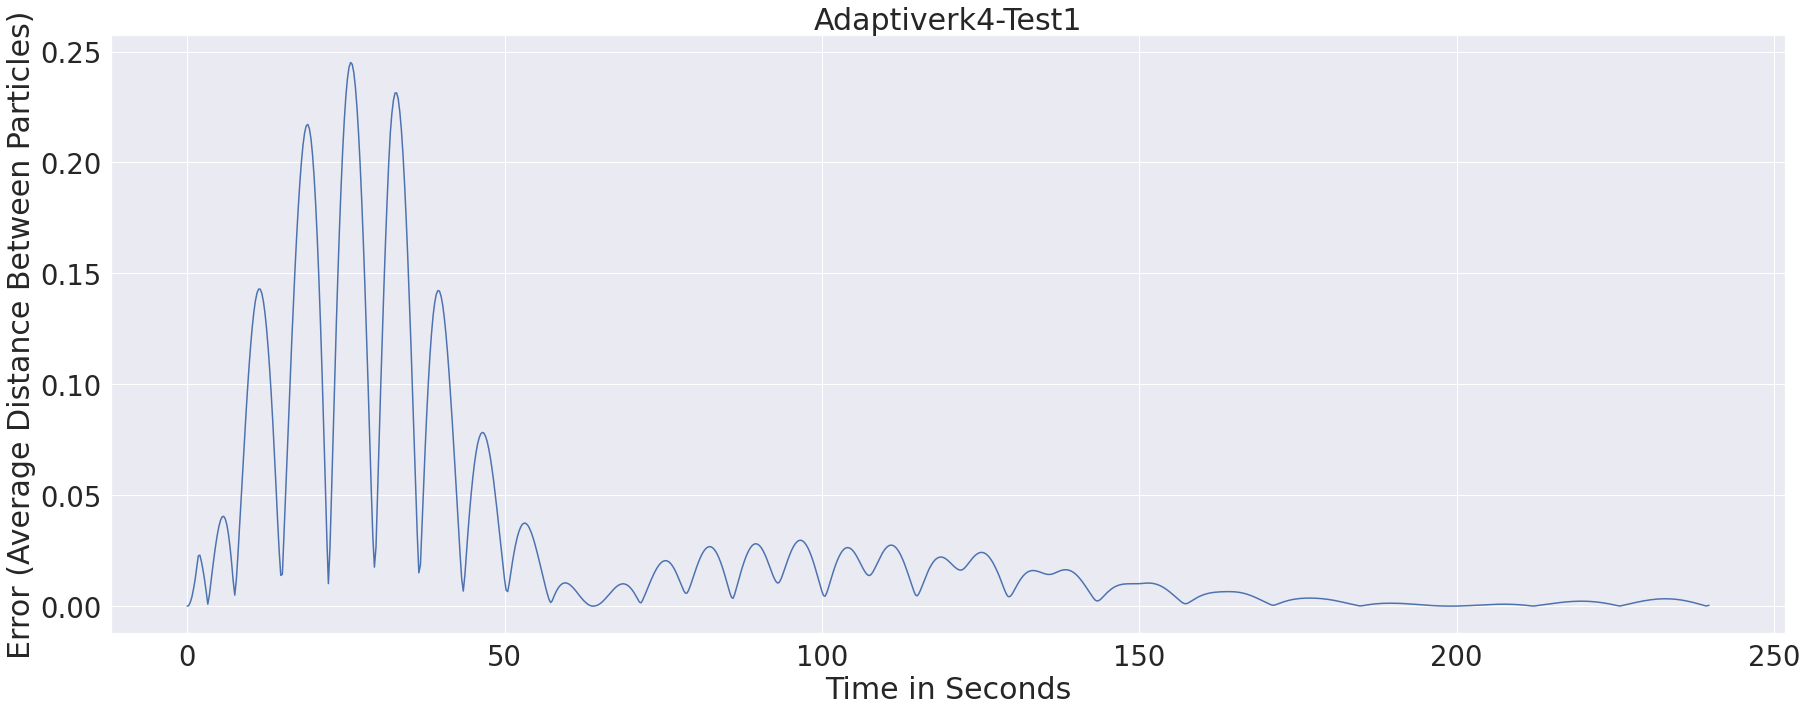

### ADAPTIVERK4 Test 2 Results

,count,mean,std,min,25%,50%,75%,max
Adaptiverk4-Test2,960.0,0.39711,0.263574,0.00001,0.227298,0.390569,0.512692,0.930646


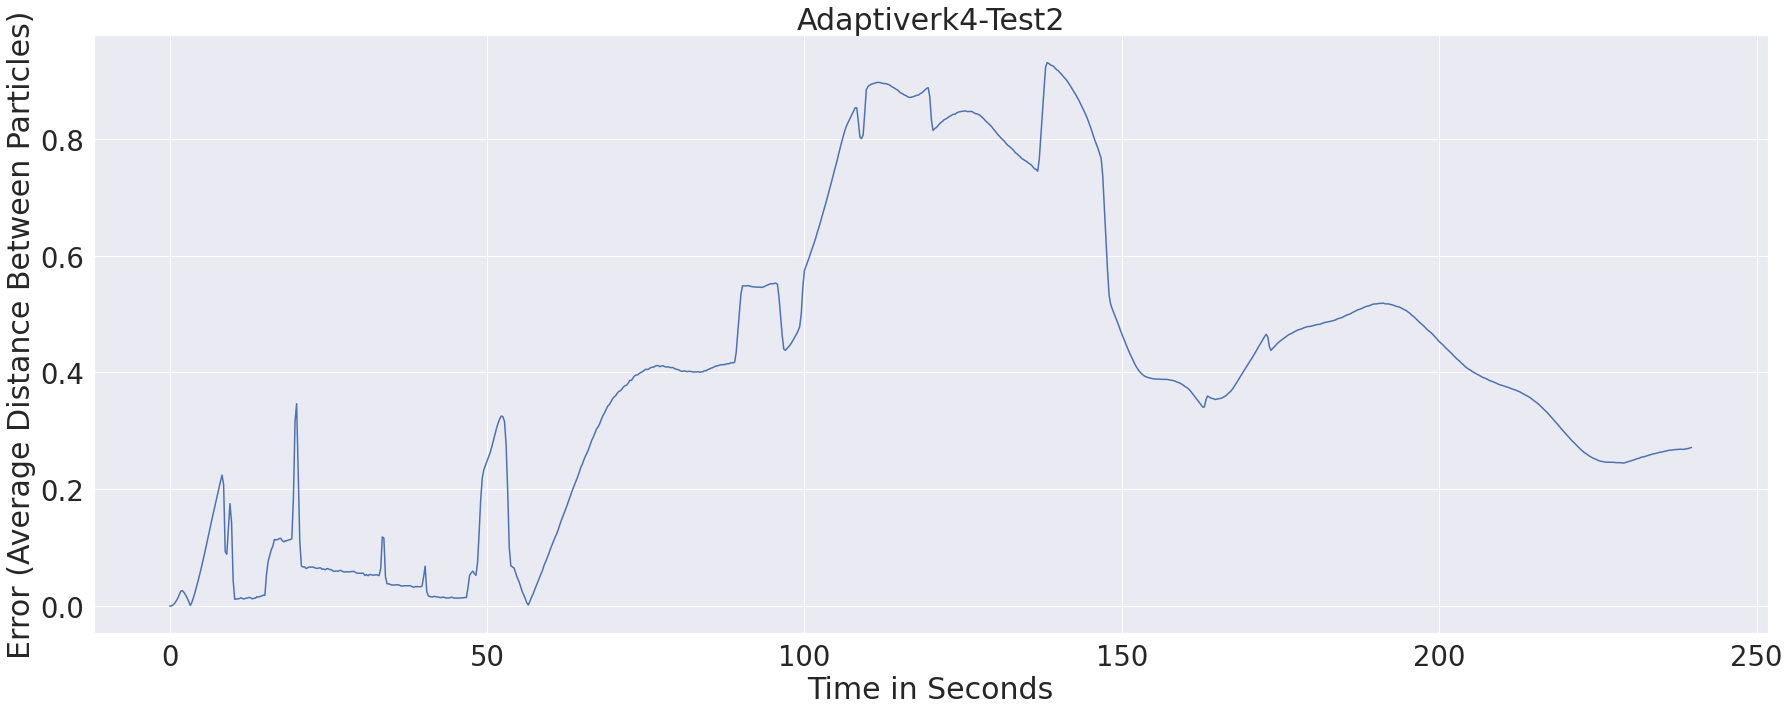

\pagebreak

### ADAPTIVERK4 Test 3 Results

,count,mean,std,min,25%,50%,75%,max
Adaptiverk4-Test3,960.0,0.398567,0.29205,0.00001,0.031993,0.429513,0.646001,0.895372


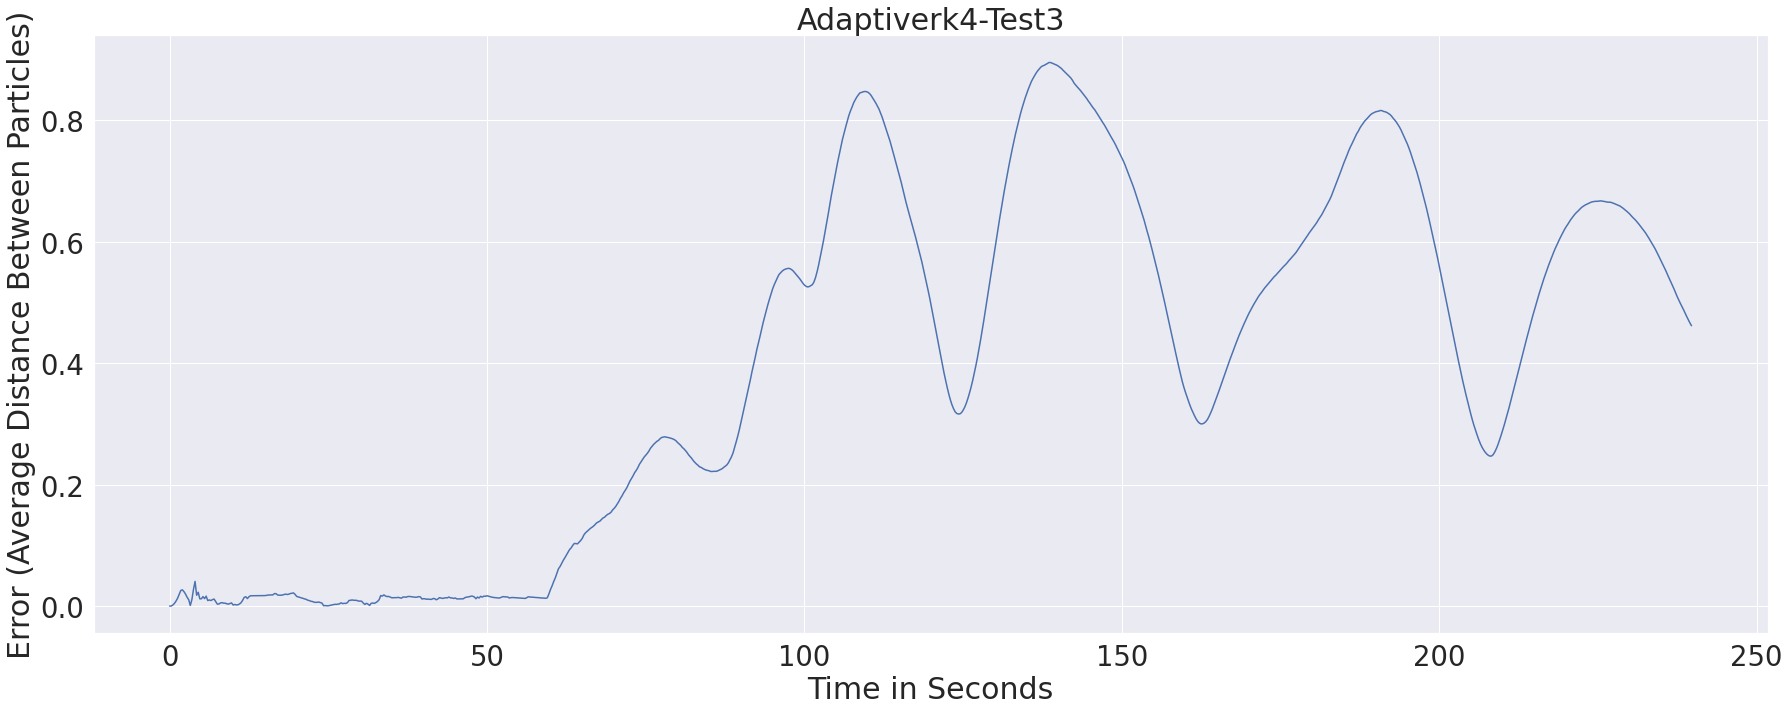

### HEUN Test 1 Results

,count,mean,std,min,25%,50%,75%,max
Heun-Test1,960.0,0.200569,0.272599,0.000979,0.043249,0.089809,0.226279,1.407952


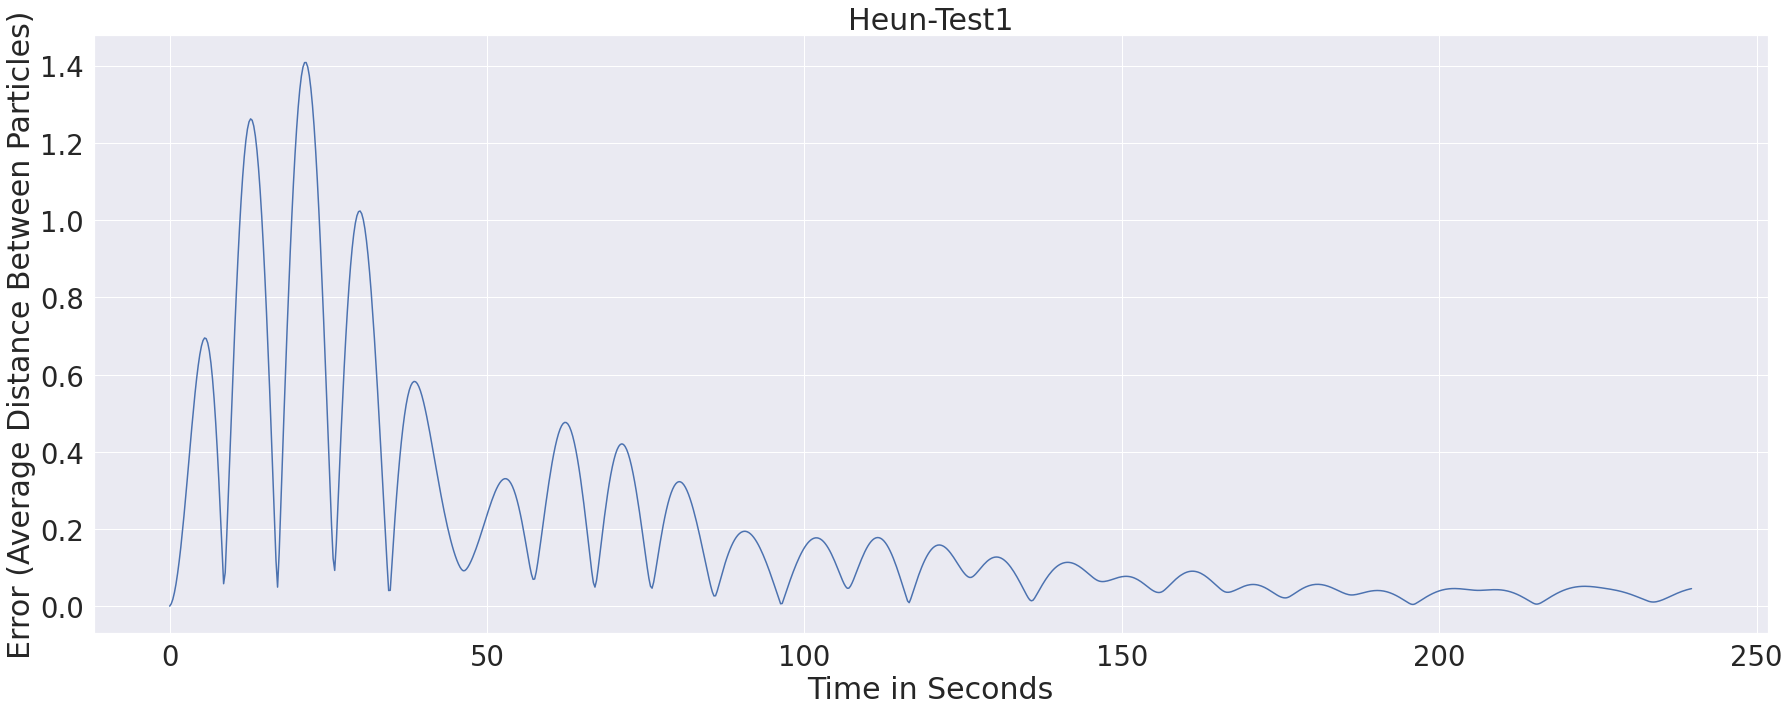

\pagebreak

### HEUN Test 2 Results

,count,mean,std,min,25%,50%,75%,max
Heun-Test2,960.0,1.601195,0.542275,0.000985,1.331452,1.550308,1.871948,2.801356


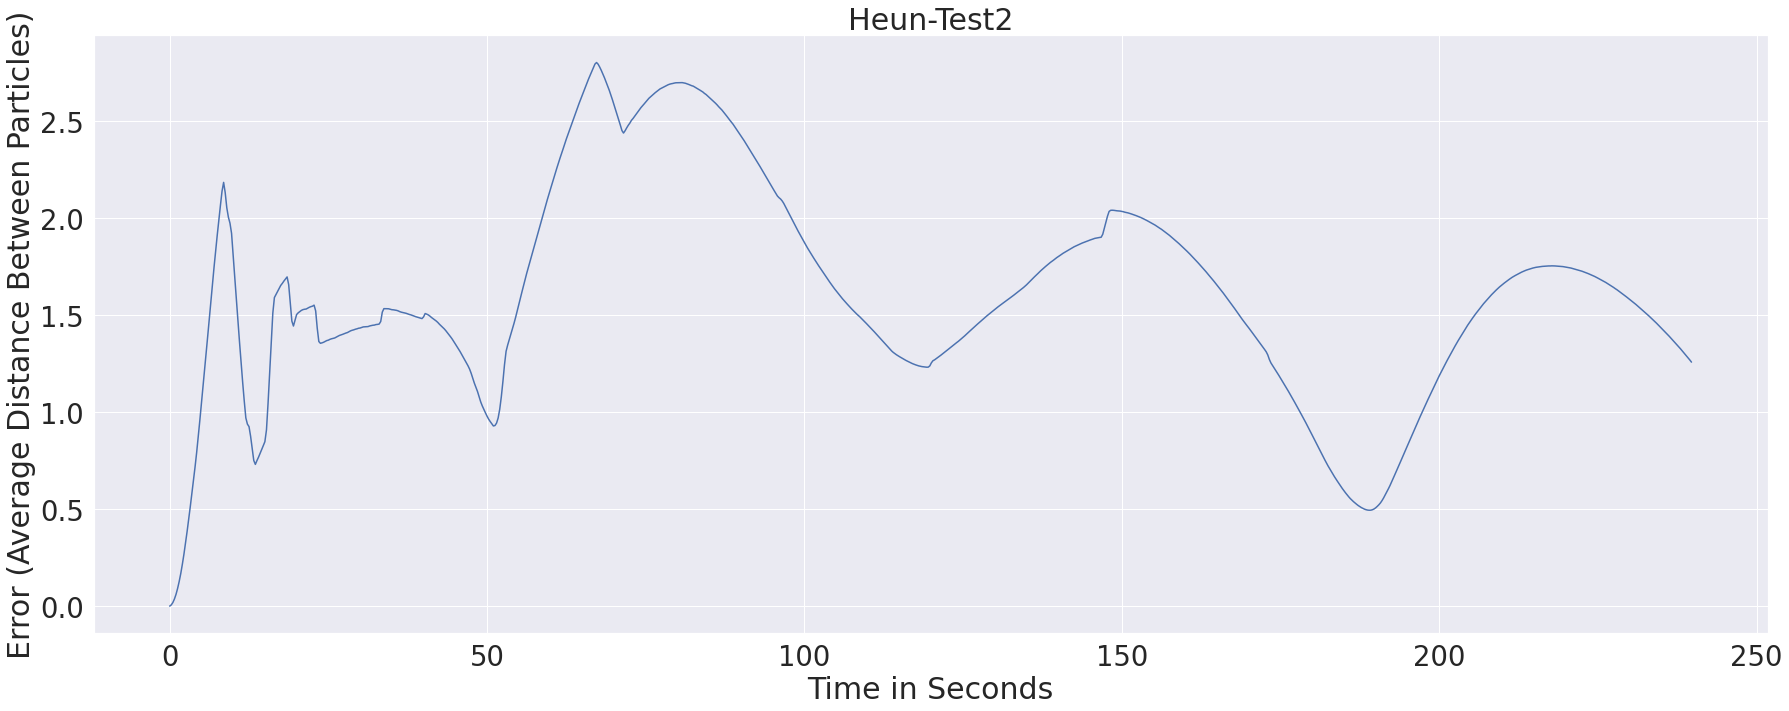

### HEUN Test 3 Results

,count,mean,std,min,25%,50%,75%,max
Heun-Test3,960.0,0.911553,0.597761,0.000126,0.495348,0.787156,1.154473,3.137841


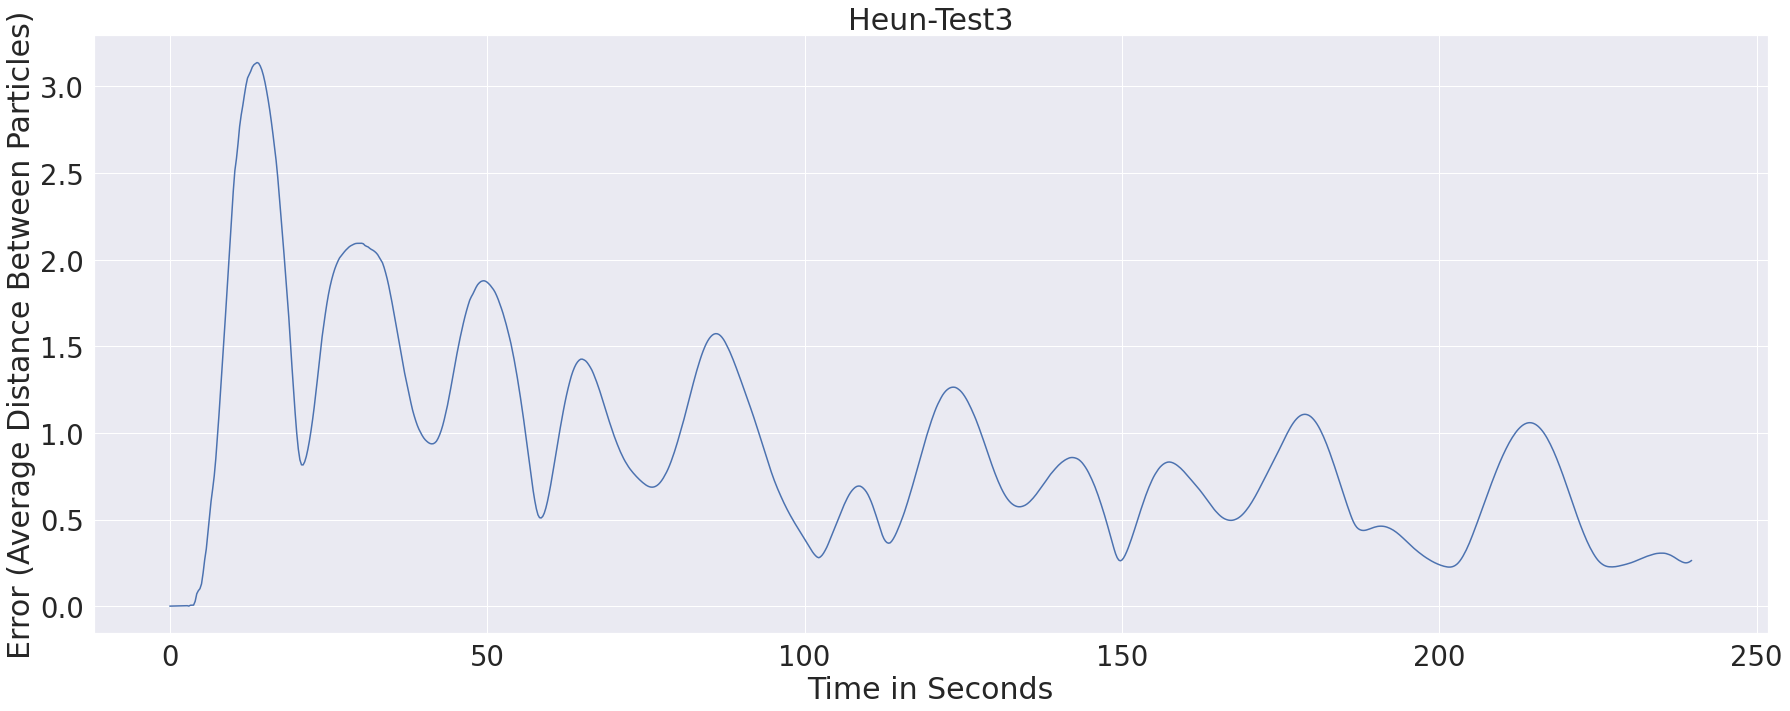

\pagebreak

### RK4 Test 1 Results

,count,mean,std,min,25%,50%,75%,max
Rk4-Test1,960.0,2.237405e-07,7.584915e-08,4.380328e-11,1.684821e-07,2.132327e-07,2.704770e-07,4.854779e-07


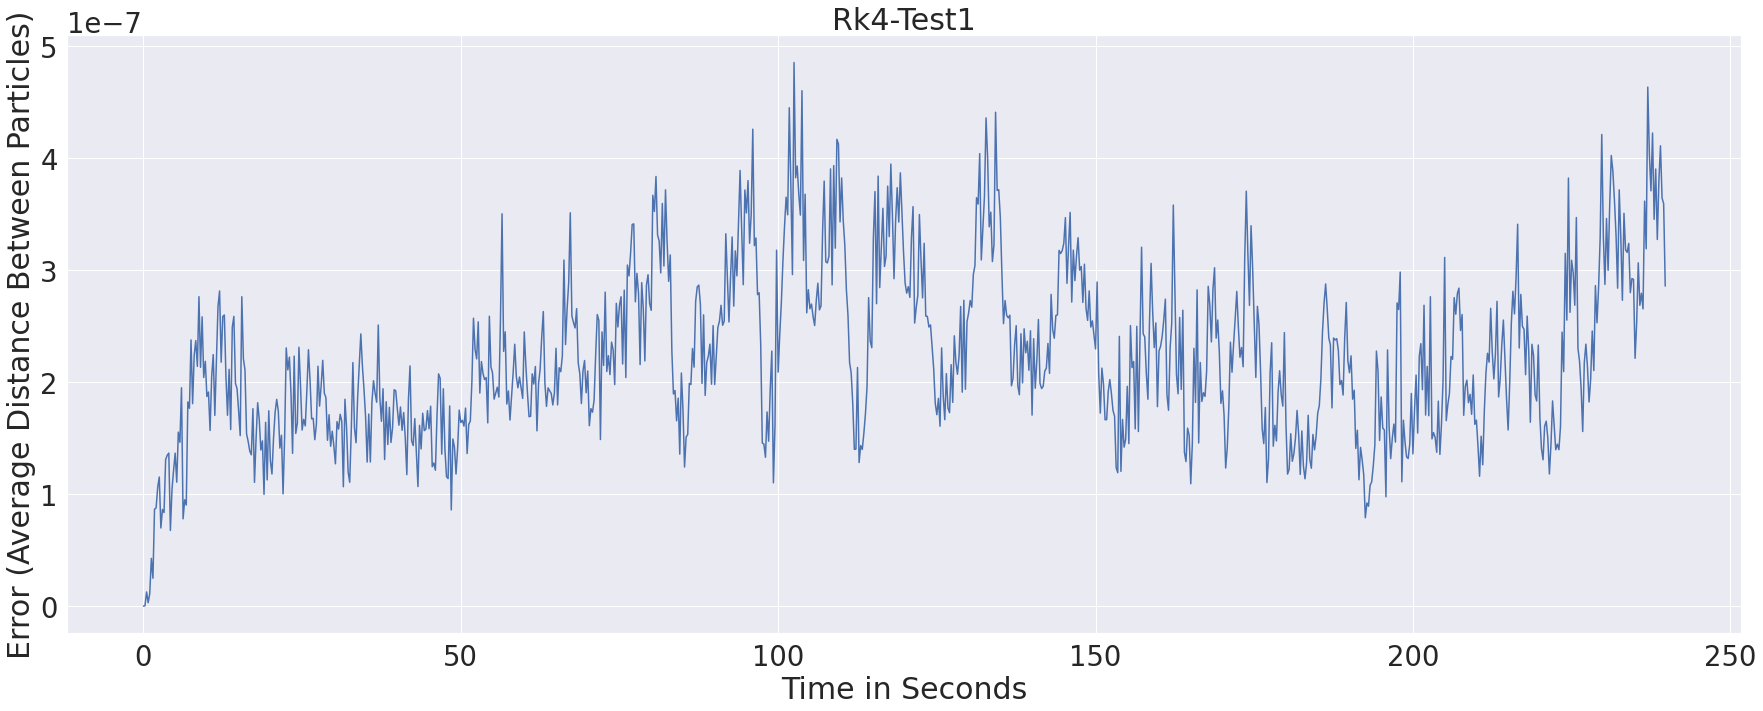

### RK4 Test 2 Results

,count,mean,std,min,25%,50%,75%,max
Rk4-Test2,960.0,0.004505,0.004253,1.585681e-10,0.002367,0.003809,0.006436,0.032198


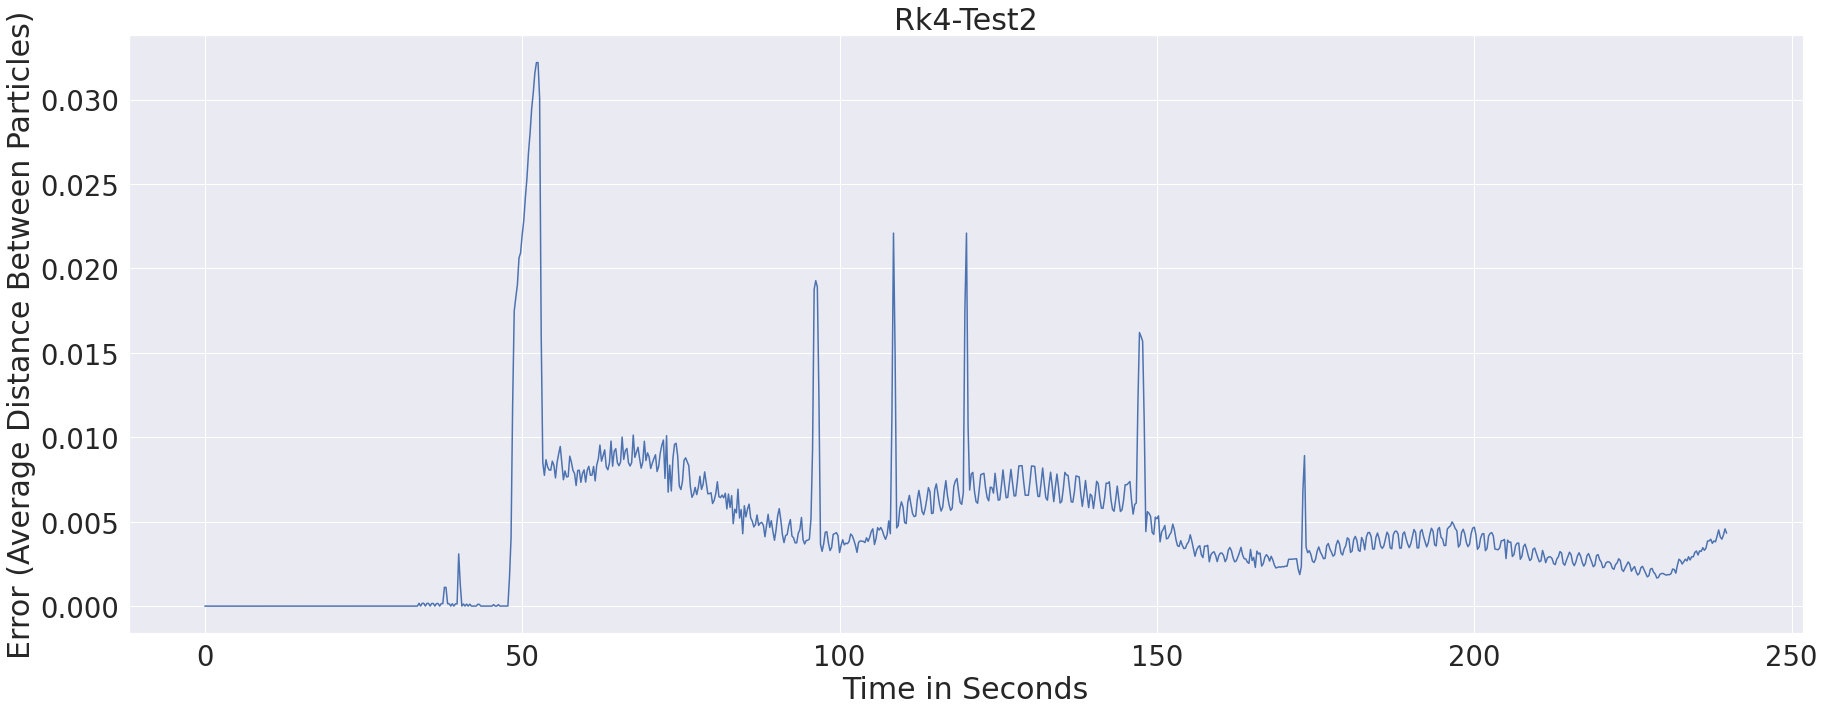

\pagebreak

### RK4 Test 3 Results

,count,mean,std,min,25%,50%,75%,max
Rk4-Test3,960.0,0.000498,0.000562,4.409171e-11,0.000068,0.000322,0.000676,0.004435


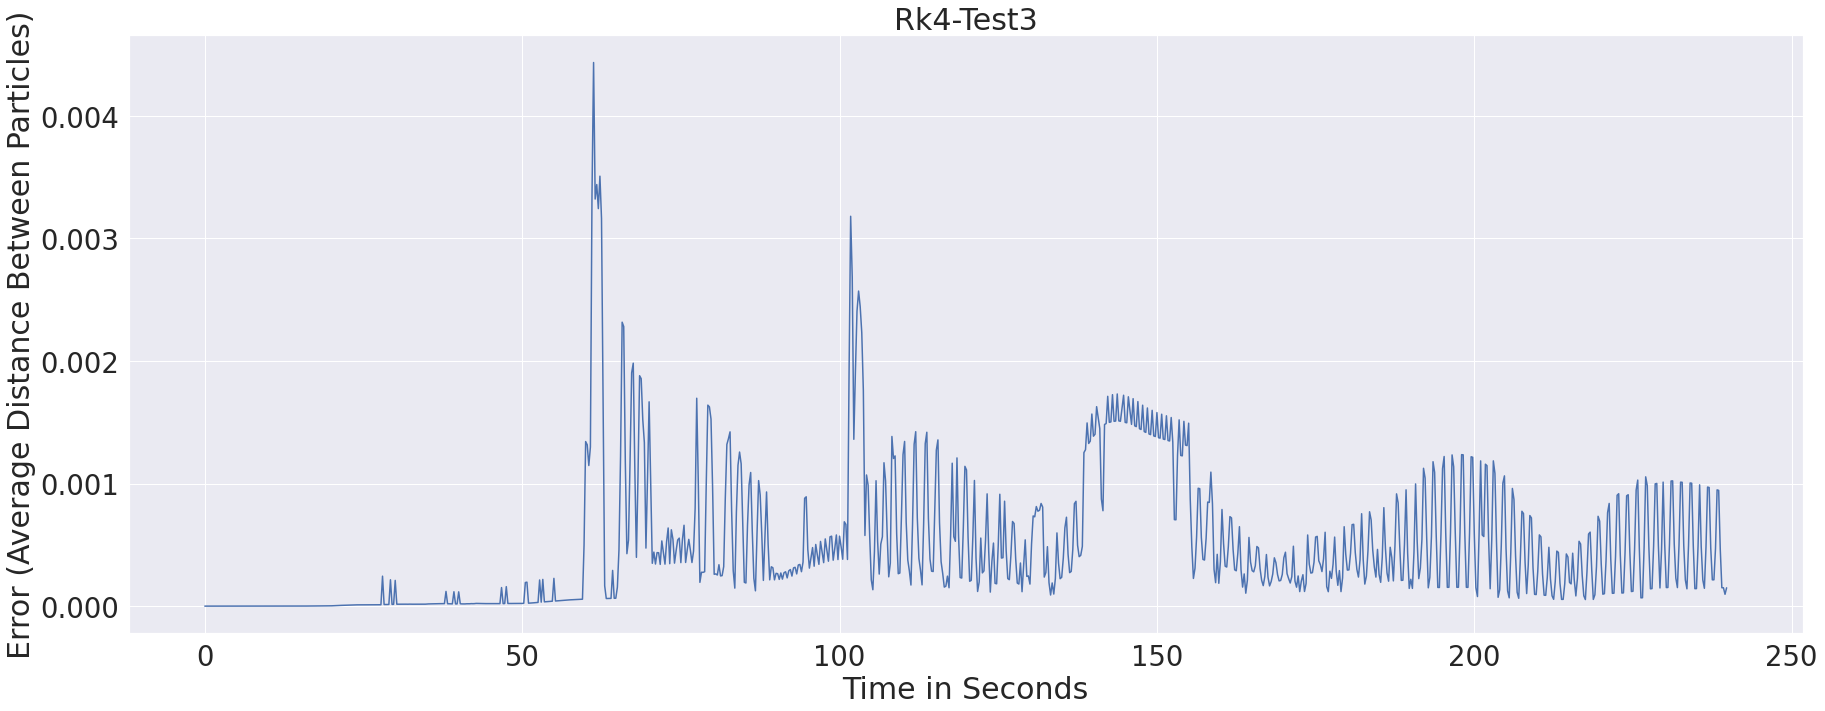

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

sns.set(rc={'figure.figsize':(30,11)}, font_scale=2.5)

display(Markdown("\pagebreak"))

for ix, df, name in zip(range(len(error_dfs)), error_dfs, files_excluding_rk5):
    test_name = f"{' '.join([s.title() for s in name.split('.')[:-1]])}"
    display(Markdown(f"### {test_name[:-1].split('-')[0].upper()} {test_name[:-1].split('-')[1].title()} {test_name[-1]} Results"))
    df[test_name] = df['error']
    display(df.describe()[[test_name]].transpose())
    df['time'] = df.apply(lambda row: int(row.name)*0.25, axis=1)
    try:
        combined_df = pd.concat([combined_df, df.describe()[[test_name]].transpose()])
    except:
        combined_df = df.describe()[[test_name]].transpose()
    ax = sns.lineplot(data=df, x='time', y='error')
    ax.set(xlabel='Time in Seconds', ylabel='Error (Average Distance Between Particles)', title=test_name)
    plt.show()
    if ix % 2 != 0:
        display(Markdown("\pagebreak"))

In [9]:
combined_df

,count,mean,std,min,25%,50%,75%,max
Adaptiverk4-Test1,960.0,2.783975e-02,4.949013e-02,2.418725e-06,2.213080e-03,9.919838e-03,2.364151e-02,2.450708e-01
Adaptiverk4-Test2,960.0,3.971101e-01,2.635744e-01,1.010462e-05,2.272984e-01,3.905686e-01,5.126916e-01,9.306464e-01
Adaptiverk4-Test3,960.0,3.985668e-01,2.920495e-01,1.017311e-05,3.199258e-02,4.295131e-01,6.460005e-01,8.953724e-01
Heun-Test1,960.0,2.005688e-01,2.725990e-01,9.792633e-04,4.324898e-02,8.980912e-02,2.262794e-01,1.407952e+00
Heun-Test2,960.0,1.601195e+00,5.422747e-01,9.853182e-04,1.331452e+00,1.550308e+00,1.871948e+00,2.801356e+00
Heun-Test3,960.0,9.115530e-01,5.977611e-01,1.256250e-04,4.953476e-01,7.871555e-01,1.154473e+00,3.137841e+00
Rk4-Test1,960.0,2.237405e-07,7.584915e-08,4.380328e-11,1.684821e-07,2.132327e-07,2.704770e-07,4.854779e-07
Rk4-Test2,960.0,4.504559e-03,4.253269e-03,1.585681e-10,2.366723e-03,3.808852e-03,6.436079e-03,3.219823e-02
Rk4-Test3,960.0,4.977654e-04,5.618401e-04,4.409171e-11,6.828317e-05,3.222026e-04,6.759377e-04,4.435306e-03


# Discussion of Benchmarks
Compared to RK5 the best performing method is RK4, followed by adaptive rk4, and lastly Heun's method.

We would expect adaptive RK4 to perform better than RK4 but the reason why it doesn't in this simulation is that during the adaptive RK4 simulation, the "m_CollisionRootFinding" is triggered in multiple iterations causing the simulation to default to Euler's integration during that iteration